In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [2]:
n_samples = 100
X = pd.DataFrame(np.random.randn(n_samples, 2), columns = ['X1','X2'])
y = 3 * X['X1'] + 2 + pd.Series(np.random.randn(n_samples).squeeze(), name='y')

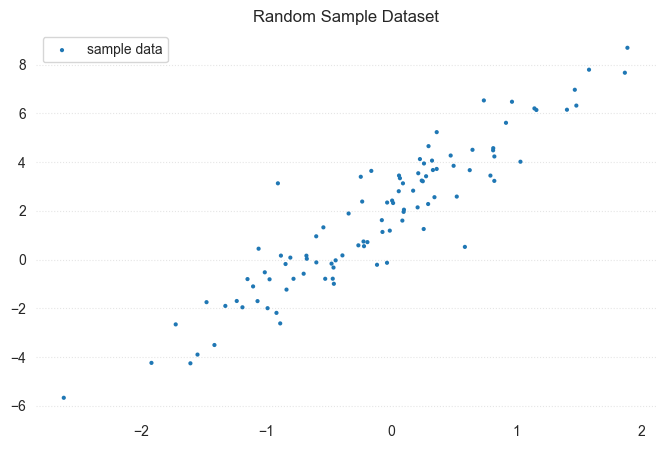

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(X['X1'], y, label = 'sample data', lw = 0.5, marker = '.', edgecolor = 'None')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Random Sample Dataset')
plt.show()

In [4]:
from FinancialDeepLearning.regression.linear_model import LinearNet
linear_net = LinearNet(X, y)

In [5]:
linear_net_fit = linear_net.fit(
    criterion = 'mse',
    optimizer = 'SGD',
    activation_function = 'silu',
    hidden_layers = [],
    learning_rate = 0.01,
    num_epochs = 10
)

100%|██████████| 10/10 [00:00<00:00, 51.91it/s]


In [6]:
print(linear_net.summary())

                    LinearNet Results
Dep. Variable:    predicted        R-squared:     0.0610  
Model:            LinearNet        MSE:           7.9812  
Date:             Mon, 30 Sep 2024 Log Likelihood -247.271
Time:             00:46:30         AIC            502.543 
Sample:           100              BIC            512.963 
No. Observations: 100              HQIC           506.760 
-----------------------------------------------------------
            coef   std err    t     P>|t|    [0.025  0.975]
-----------------------------------------------------------
const      0.1903   1.4994  0.1269  0.8993  -2.7486  3.1291
X1         0.8591   0.3317  2.5896  0.0111   0.2089  1.5093
X2         0.4732   0.2844  1.6638  0.0994  -0.0843  1.0306
----------------------------------------------------------
Ljung-Box (L1) (Q):        10.23  Jarque-Bera (JB):  1.74 
Prob(Q):                   0.42   Prob(JB):          0.42 
Heteroskedasticity (H):    45.22  Skew:              -0.02
Prob(H) (two

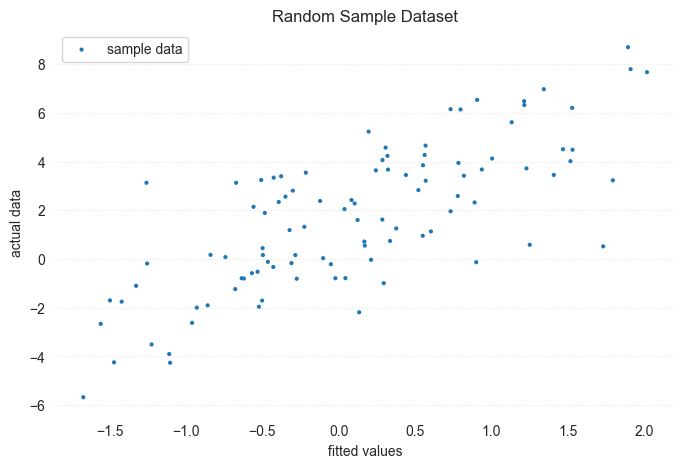

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    linear_net.fittedvalues(), y, 
    label = 'sample data', 
    lw = 0.5,
    marker = '.', 
    edgecolor = 'None'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('fitted values')
plt.ylabel('actual data')
plt.title('Random Sample Dataset')
plt.show()

### Factor Models with Neural Net

In [8]:
import pandas_datareader as pdr

data = pdr.DataReader(
    'F-F_Research_Data_Factors_daily', 
    'famafrench', 
    start = '1980-01-01'
)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_57501/2413652644.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.DataReader(


In [9]:
fama = data[0].astype(float) * 0.01

In [10]:
fama['RF'] = ((fama['RF'] * 100) / 252)

In [11]:
fama.index = pd.to_datetime(fama.index)

In [12]:
import yfinance as yf

aapl = yf.download(
    'AAPL',
    start = '1999-12-31',
    end = '2024-08-01',
    progress = False
)

In [13]:
fama = fama.loc[aapl.index]

In [14]:
fama['asset-RF'] = aapl['Close'].pct_change().dropna() - fama['RF']

In [15]:
fama.dropna(inplace = True)

In [16]:
X = fama[['Mkt-RF','SMB','HML']]
y = fama['asset-RF']

In [17]:
linear_net = LinearNet(X, y)

In [18]:
linear_net_fit = linear_net.fit(
    criterion = 'mse',
    optimizer = 'ADAM',
    activation_function = 'silu',
    hidden_layers = [8, 4, 2],
    learning_rate = 0.1,
    num_epochs = 100
)

100%|██████████| 100/100 [00:00<00:00, 291.91it/s]


In [19]:
print(linear_net.summary())

                     LinearNet Results
Dep. Variable:    predicted        R-squared:     0.3631    
Model:            LinearNet        MSE:           0.0004    
Date:             Mon, 30 Sep 2024 Log Likelihood 15532.185 
Time:             00:46:55         AIC            -31054.369
Sample:           6183             BIC            -31020.722
No. Observations: 6183             HQIC           -31042.702
------------------------------------------------------------
         coef   std err      t      P>|t|   [0.025   0.975] 
------------------------------------------------------------
const   -2.3992  0.0001 -23063.0068 0.0000  -2.3994  -2.3990
Mkt-RF -22.3993  0.0203  -1104.4965 0.0000 -22.4391 -22.3596
SMB      1.6303  0.0393     41.4603 0.0000   1.5532   1.7073
HML     11.3528  0.0319    355.4405 0.0000  11.2902  11.4154
------------------------------------------------------------
Ljung-Box (L1) (Q):       33.47 Jarque-Bera (JB): 1338470.23
Prob(Q):                  0.00  Prob(JB):     

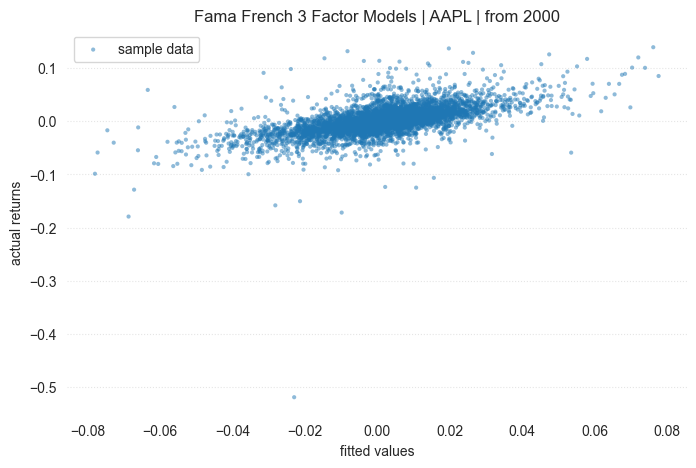

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    linear_net.fittedvalues(), y, 
    label = 'sample data', 
    lw = 0.5,
    marker = '.', 
    edgecolor = 'None',
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('fitted values')
plt.ylabel('actual returns')
plt.title('Fama French 3 Factor Models | AAPL | from 2000')
plt.show()